# Introduction to TPC-H

## What is TPC-H?

**TPC-H** is a benchmark dataset developed by the [Transaction Processing Performance Council (TPC)](http://www.tpc.org/tpch/). It simulates a **decision-support system**, the kind used in businesses for reporting, analytics, and forecasting.

It's widely used in both academia and industry to test:

- SQL query performance
- Database optimization
- Data warehousing systems

---

## What Does the Data Represent?

TPC-H models a **fictional wholesale supplier** that processes **customer orders for parts** across different nations and regions.

The dataset captures business activities like:

- Placing orders
- Supplying and shipping parts
- Managing suppliers and customers

---

## Tables in TPC-H

The schema includes **8 primary tables**:

| Table      | Description |
|------------|-------------|
| `customer` | Customer details (name, address, market segment) |
| `orders`   | Orders placed by customers |
| `lineitem` | Line-level details of each order |
| `part`     | Parts available for sale |
| `partsupp` | Part-supplier relationship with pricing |
| `supplier` | Supplier information |
| `nation`   | Country data for customers/suppliers |
| `region`   | Regional grouping of nations |

These tables are **relationally connected** using primary and foreign keys — ideal for practicing joins and complex queries.

---

## TPC-H Queries

TPC-H comes with **22 standard analytical queries** (Q1–Q22) that test your ability to:

- Analyze sales, revenue, discounts, supply costs
- Work with subqueries and grouped aggregations
- Benchmark performance at scale


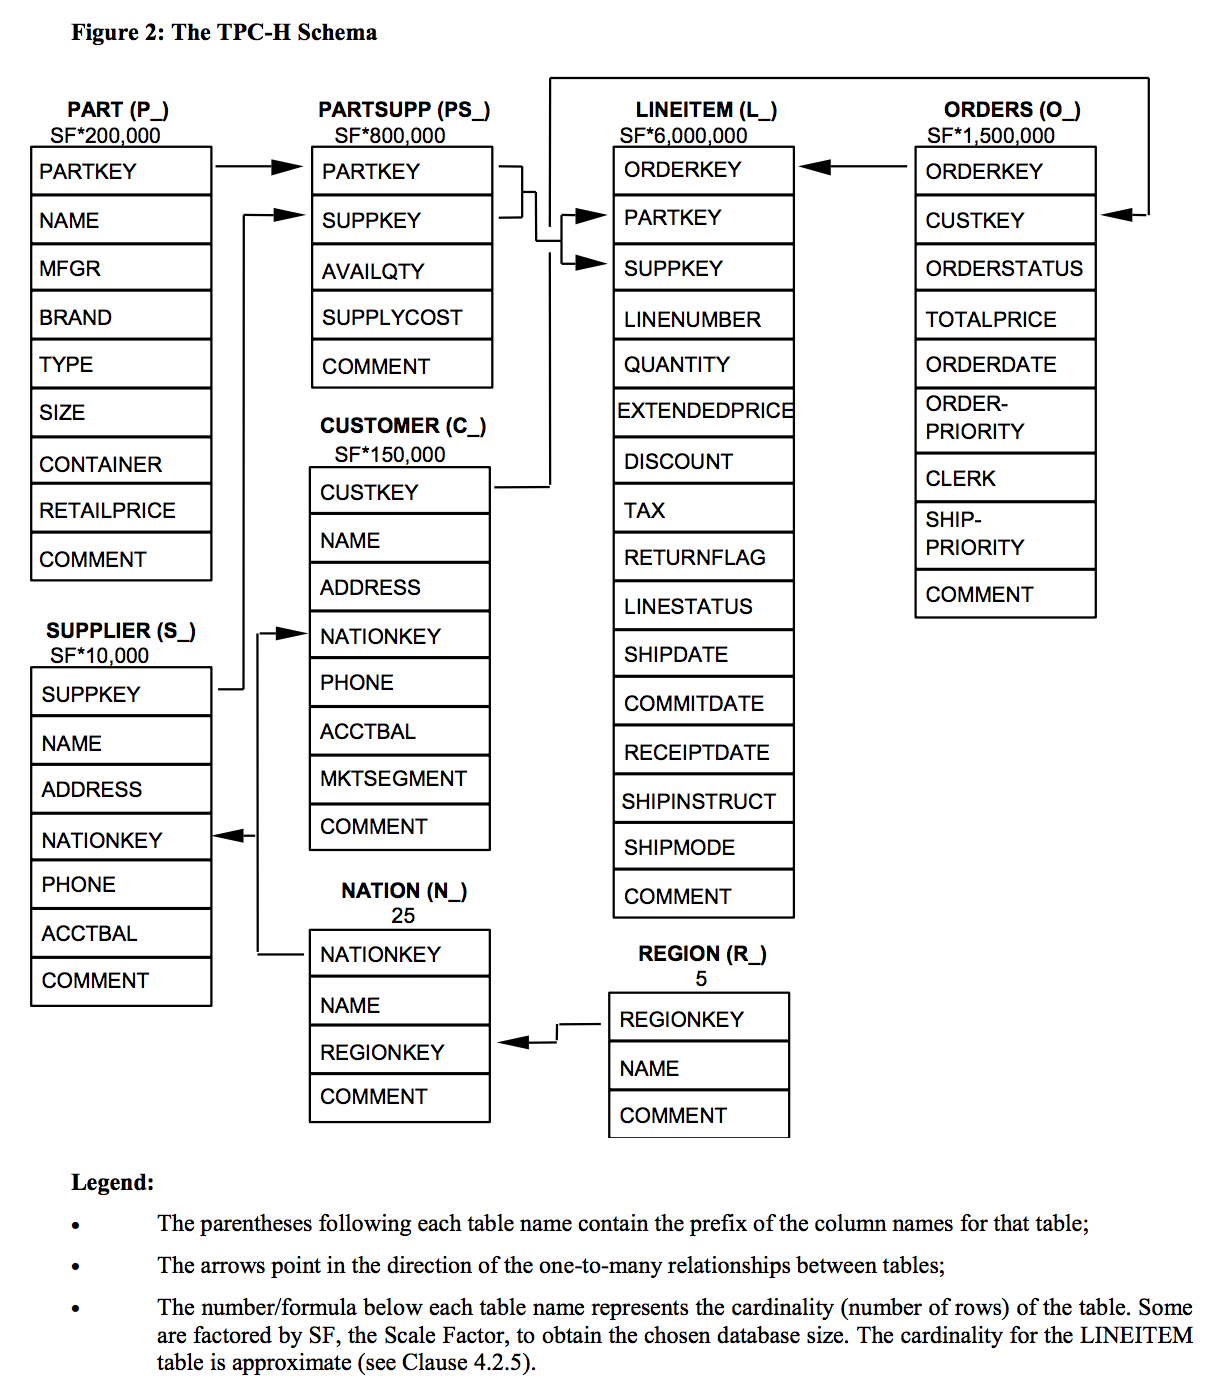

In [1]:
from IPython.display import Image

Image(filename='sample-data-tpch-schema.png')


In [ ]:
# Imports

from tabulate import tabulate
import psycopg2
import time

In [ ]:
import mysql.connector

# Connection parameters
conn = mysql.connector.connect(
    host="mysql_db",
    user="user",
    password="user_password",
    database="banking_db",  # or tpch_db if you change it later
    port=3306
)

# Create a cursor and run a query
cur = conn.cursor()
cur.execute("DESCRIBE lineitem;")
for row in cur.fetchall():
    print(row)


# TPC-H Query 1: Sales Summary by Status

###  Goal: We want to analyze **sales performance** by return status and shipping status.

### What Do These Fields Mean?

- **`l_returnflag`**: 
  - `'R'` = Returned
  - `'A'` = Not returned ("All shipped")
  - `'N'` = Not returned ("Normal")
  
- **`l_linestatus`**: 
  - `'F'` = Filled (shipped)
  - `'O'` = Open (not yet shipped)


This query:
- Groups the data by `l_returnflag` and `l_linestatus`
- Calculates totals and averages for quantities, prices, and discounts
- Filters for line items shipped **before a certain date**

In [ ]:
cur.execute("""
    SELECT
        l_returnflag,
        l_linestatus,
        SUM(l_quantity) AS sum_qty,
        SUM(l_extendedprice) AS sum_base_price,
        SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
        SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
        AVG(l_quantity) AS avg_qty,
        AVG(l_extendedprice) AS avg_price,
        AVG(l_discount) AS avg_disc,
        COUNT(*) AS count_order
    FROM lineitem
    WHERE l_shipdate <= DATE_SUB(DATE('1998-12-01'), INTERVAL 90 DAY)
    GROUP BY l_returnflag, l_linestatus
    ORDER BY l_returnflag, l_linestatus

""")

# Fetch all records from the result
records = cur.fetchall()

# Fetch column names
col_names = [desc[0] for desc in cur.description]

# Print the records in table format
print(tabulate(records, headers=col_names, tablefmt="grid"))


# TPC-H Query 9: Profit by Nation and Year (Green Parts)

### Goal: We want to analyze **profits across nations over time**, but only for **parts that have "green" in their name**.


### What the Query Does:

1. Joins multiple tables to connect:
   - Parts to suppliers
   - Suppliers to line items
   - Line items to orders and nations

2. Filters for parts with names containing **"green"**

3. Calculates **profit** per line item:
   - `revenue - supply cost` →   `l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity`

4. Groups by **nation** and **order year**, and sums the profit

In [ ]:
cur.execute("""
select
        nation,
        o_year,
        sum(amount) as sum_profit
from
        (
                select
                        n_name as nation,
                        extract(year from o_orderdate) as o_year,
                        l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity as amount
                from
                        part,
                        supplier,
                        lineitem,
                        partsupp,
                        orders,
                        nation
                where
                        s_suppkey = l_suppkey
                        and ps_suppkey = l_suppkey
                        and ps_partkey = l_partkey
                        and p_partkey = l_partkey
                        and o_orderkey = l_orderkey
                        and s_nationkey = n_nationkey
                        and p_name like '%green%'
        ) as profit
group by
        nation,
        o_year
order by
        nation,
        o_year desc
limit 10

""")

# Fetch all records from the result
records = cur.fetchall()

# Fetch column names
col_names = [desc[0] for desc in cur.description]

# Print the records in table format
print(tabulate(records, headers=col_names, tablefmt="grid"))

# TPC-H Query 11: Valuable Parts in Germany

### Goal: Find the parts supplied by **German suppliers** that represent the **most valuable inventory**.

---

### What the Query Does:

1. Joins `partsupp`, `supplier`, and `nation`
2. Filters for **suppliers from Germany**
3. Calculates the **inventory value** for each part:
   - `ps_supplycost * ps_availqty`
4. Keeps only the parts whose total value is **greater than 0.01%** of all inventory value in Germany
5. Sorts them by total value, highest first


In [ ]:
cur.execute("""
select
        ps_partkey,
        sum(ps_supplycost * ps_availqty) as "value"
from
        partsupp,
        supplier,
        nation
where
        ps_suppkey = s_suppkey
        and s_nationkey = n_nationkey
        and n_name = 'GERMANY'
group by
        ps_partkey having
                sum(ps_supplycost * ps_availqty) > (
                        select
                                sum(ps_supplycost * ps_availqty) * 0.0001
                        from
                                partsupp,
                                supplier,
                                nation
                        where
                                ps_suppkey = s_suppkey
                                and s_nationkey = n_nationkey
                                and n_name = 'GERMANY'
                )
order by
        "value" desc
limit 10


""")

# Fetch all records from the result
records = cur.fetchall()

# Fetch column names
col_names = [desc[0] for desc in cur.description]

# Print the records in table format
print(tabulate(records, headers=col_names, tablefmt="grid"))

# TPC-H Query 13: Customers and Order Activity

### Goal: We want to understand how many customers have made a certain number of orders — **excluding special request orders**.

### What the Query Does:

1. Joins `customer` and `orders` (with a **LEFT OUTER JOIN**)
2. **Ignores orders that mention "special requests"** in the comment field
3. Counts how many orders each customer made
4. Groups customers by their order count
5. Counts how many customers fall into each group

---

### Result Example:

| c_count (orders) | custdist (customers) |
|------------------|----------------------|
| 0                | 4000                 |
| 1                | 1200                 |
| 2                | 600                  |
| ...              | ...                  |

This tells us:
- How many customers placed 0, 1, 2, ... orders
- How common different levels of ordering behavior are


In [ ]:
cur.execute("""
select
        c_count,
        count(*) as custdist
from
        (
                select
                        c_custkey,
                        count(o_orderkey) c_count
                from
                        customer left outer join orders on
                                c_custkey = o_custkey
                                and o_comment not like '%special%requests%'
                group by
                        c_custkey
        ) as c_orders
group by
        c_count
order by
        custdist desc,
        c_count desc
limit 10


""")

# Fetch all records from the result
records = cur.fetchall()

# Fetch column names
col_names = [desc[0] for desc in cur.description]

# Print the records in table format
print(tabulate(records, headers=col_names, tablefmt="grid"))

# TPC-H Query 15: Top Supplier by Revenue

### Goal: Find out **which supplier made the most revenue** in a specific time period.

---

### Time Window:
We look at orders **shipped between January 1 and March 31, 1996**.

---

### What the Query Does:

1. Calculates total revenue for each supplier (after discounts)
2. Finds the supplier(s) with the **highest revenue**
3. Returns their info: name, address, phone, and revenue


In [ ]:
cur.execute("""
    
with revenue as (
	select
		l_suppkey as supplier_no,
		sum(l_extendedprice * (1 - l_discount)) as total_revenue
	from
		lineitem
	where
		l_shipdate >= date '1996-01-01'
		and l_shipdate < date '1996-04-01'
	group by
		l_suppkey
)
select
	s_suppkey,
	s_name,
	s_address,
	s_phone,
	total_revenue
from
	supplier,
	revenue
where
	s_suppkey = supplier_no
	and total_revenue = (
		select max(total_revenue)
		from revenue
	)
order by
	s_suppkey

""")

# Fetch all records from the result
records = cur.fetchall()

# Fetch column names
col_names = [desc[0] for desc in cur.description]

# Print the records in table format
print(tabulate(records, headers=col_names, tablefmt="grid"))